In [23]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import words
import nltk
from nltk.stem import WordNetLemmatizer
import warnings
import string
warnings.simplefilter('ignore')
nltk.download('words')

eng_set = set(words.words())
stopwords = nltk.corpus.stopwords.words('english')
lemm = WordNetLemmatizer()
punct = set(string.punctuation)

[nltk_data] Downloading package words to
[nltk_data]     /Users/vaibhavnakrani/nltk_data...
[nltk_data]   Package words is already up-to-date!


<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Cleans the text extensively</span>

- <span style="font-family: 'Bebas Neue'; font-size:1em;">The words from which the data is mined from is removed</span>
- <span style="font-family: 'Bebas Neue'; font-size:1em;">Extra words are identified from iterations of the modelling algorithm</span>

In [24]:
def clean_text(text:str):
    
    if not isinstance(text, str):  # Check if the input is a float
        text = str(text)

    #Lower case all text
    text = text.lower()
    
    if isinstance(text, float):  # Check if the input is a float
        text = str(text)
    # 1. Emoji Removal:
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"  
        u"\U000024C2-\U0001F251"  
        "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text) 

    # 2. Remove double quotation marks:
    text = text.replace('"', '')

    #Remove mentions
    pattern = r"@\w+"

    text = re.sub(pattern, '', text)

    #Clean single letters and numbers
    pattern = r'(\b[a-zA-Z]\s|\d+)'
    text = re.sub(pattern, '', text)

    # Remove Punctuations
    text = " ".join([word for word in text.split() if word not in punct])
    
    #Remove Stop words
    text = " ".join([word for word in text.split() if word not in stopwords])

    #Only words in english language
    text = " ".join([word for word in text.split() if word.lower() in eng_set])

    #Clean the corpus on what it was mined for.
    sxt = ['q', 'qresearch', 'qanon', 'rt', 'would', 'like', 'post', 'thread','posted','tweet','posting','twitter','new']
    
    text = " ".join(word for word in text.split() if word not in sxt)

    #Lemmatization
    text = lemm.lemmatize(text)

    text = text.strip()
    
    return text

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1DcWCYXWuFmWNqlqfJT8L1OpaYuuzaI9e'
output = 'final_df.csv'

gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

In [25]:
df['clean_text'] = df['text'].apply(clean_text)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [26]:
def length(row):
    text = row['clean_text']
    lst = text.split()
    return len(lst)
df['len'] = df.apply(length, axis=1)

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Removing very short posts</span>

In [27]:
len(df)
df = df[df['len'] > 5]
len(df)

555067

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Removing very long posts for computation</span>

In [28]:
len(df)
df = df[df['len'] < 200]
len(df)

553619

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Majority of the posts are after 20:00</span>

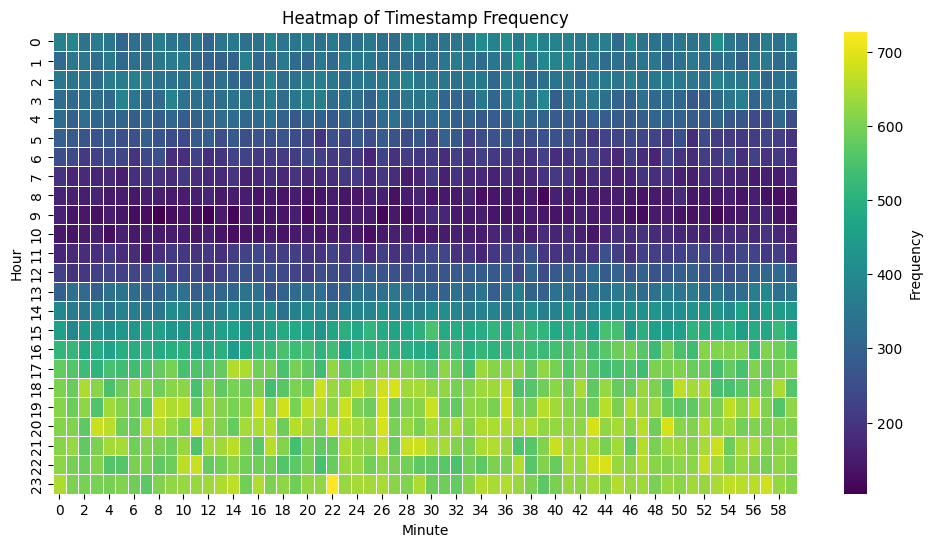

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby([df['timestamp'].dt.hour, df['timestamp'].dt.minute]).size().unstack(),
            cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Frequency'})
plt.xlabel('Minute')
plt.ylabel('Hour')
plt.title('Heatmap of Timestamp Frequency')
plt.show()

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Word Clouds for three years</span>

- <span style="font-family: 'Bebas Neue'; font-size:1em;">2018 - 2019</span>
- <span style="font-family: 'Bebas Neue'; font-size:1em;">2019 - 2020</span>
- <span style="font-family: 'Bebas Neue'; font-size:1em;">2020 - 2021</span>

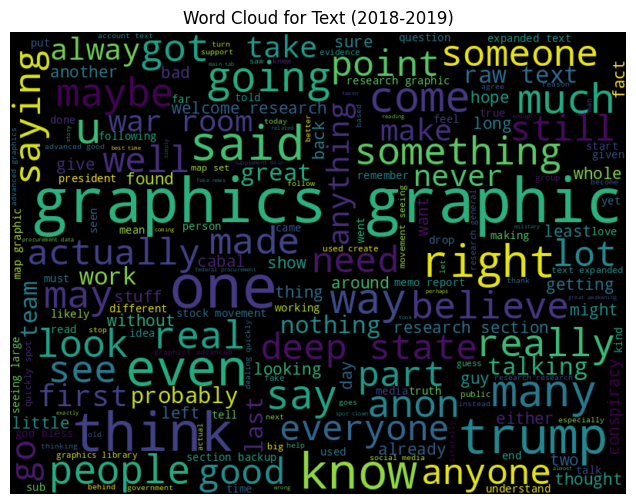

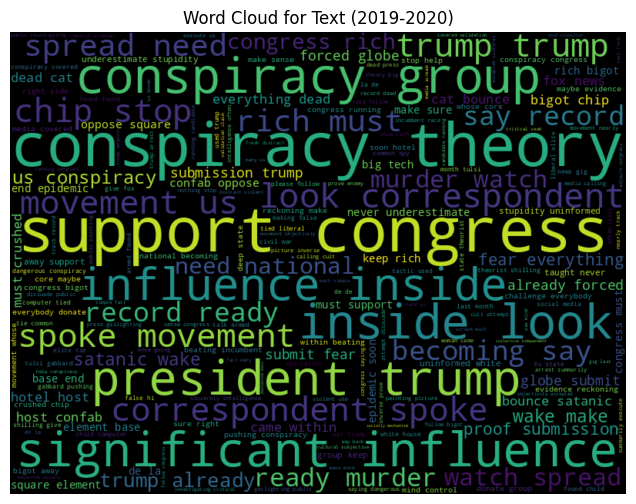

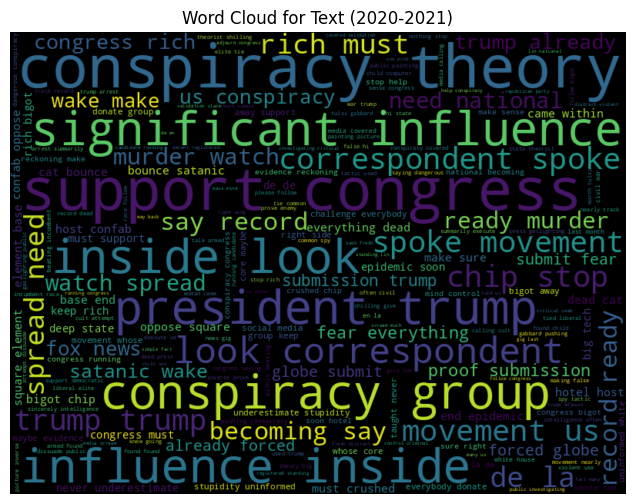

In [30]:
from wordcloud import WordCloud

ranges = [(2018, 2019), (2019, 2020), (2020, 2021)]

for year_start, year_end in ranges:
  df_filtered = df[(df['timestamp'].dt.year <= year_end) & (df['timestamp'].dt.year >= year_start)]

  text = " ".join(df_filtered["clean_text"])

  wordcloud = WordCloud(width=800, height=600).generate(text)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Word Cloud for Text ({year_start}-{year_end})")
  plt.show()

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">**Groups the dataframe with groups of 20**</span>

<span style="font-family: 'Bebas Neue'; font-size:1em;"> Since the dataset size is half a million</span>

<span style="font-family: 'Bebas Neue'; font-size:1em;"> The models can be very noisy</span>

In [31]:
df['group'] = df.index // 20

df_grouped = df.groupby('group').agg({
    'timestamp': 'last',
    'clean_text': ' '.join
}).reset_index(drop=True)

len(df_grouped)

49095

In [32]:
text = df_grouped.clean_text.to_list()
time = df_grouped.timestamp.to_list()

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">**Step 1**: Embeddings</span>

In [34]:
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
model_nm = 'BAAI/bge-base-en-v1.5'

embedding_model = SentenceTransformer(model_nm)
embeddings = embedding_model.encode(text)

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">**Step 2: Dim Reduction**</span>

#### **UMAP**

**n_neighbors**:  
- <span style="font-family: 'Bebas Neue'; font-size:1.2em;">Low value - Concentrate on local structures ~ detriment of the big picture.</span>
- <span style="font-family: 'Bebas Neue'; font-size:1.2em;">High value - Lose fine detials ~ Get high level details.</span>

**min_dist**  
- <span style="font-family: 'Bebas Neue'; font-size:1.2em;">Low -> Tight clusters</span>
- <span style="font-family: 'Bebas Neue'; font-size:1.2em;">High -> Sparse Clusters</span>

In [35]:
from umap import UMAP

reduction_model = UMAP(n_components = 5,n_jobs = -1,metric = 'cosine',random_state = 42)

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">**Step 3: Clustering**</span>

#### **HDBSCAN**  
**min_cluster_size:**  
<span style="font-family: 'Bebas Neue'; font-size:1.2em;">The minimum number of samples in a group for that group to be considered a cluster; groupings smaller than this size will be left as noise.</span>

In [36]:
from sklearn.cluster import KMeans, HDBSCAN
cluster_model = HDBSCAN(n_jobs = -1,min_cluster_size = 250,metric = 'euclidean')

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">**Step 4: vectorizer for topics.**</span>
<span style="font-family: 'Bebas Neue'; font-size:1.2em;">
One often underestimated component of BERTopic is the CountVectorizer and c-TF-IDF calculation. Together, they are responsible for creating the topic representations and luckily can be quite flexible in parameter tuning. 

can be fitted after training the model

topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

Increase the value of min_df if processing very large documents.

A parameter similar to min_df is max_features which allows you to select the top n most frequent words to be used in the topic representation. Helps

control the size of topic-term matrix. max_faetures = 10,000.
</span> 


In [37]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english",ngram_range=(1,3))

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">In BERTopic, in order to get an accurate representation of the topics from our bag-of-words matrix, TF-IDF was adjusted to work on a cluster/categorical/topic level instead of a document level. c-tf-idf.</span>

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Each cluster is converted to a single document instead of a set of documents. Then, we extract the frequency of word x in class c, where c refers to the cluster we created before.</span>

<span style="font-family: 'Bebas Neue'; font-size:1.2em;">Since the topic representation is somewhat independent of the clustering step, we can change how the c-TF-IDF representation will look like. This can be in the form of parameter tuning, different weighting schemes, or using a diversity metric on top of it.</span>

In [38]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer()


### <span style="font-family: 'Bebas Neue'; font-size:1.2em;"> Key Bert inspired</span>

- Key bert uses Which uses BERT-embeddings and simple cosine similarity to find the sub-phrases in a document that are the most similar to the document itself.</span>

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">Parts of speech</span>

- c-tf-idf does not take into account candidates part of speech.

- we find documents that contain the keywords from our candidate topics as calculated with c-TF-IDF. These documents serve as the representative set of documents from which the Spacy model can extract a set of candidate keywords for each topic</span>

### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">Maximum marginal relevance

- we typically do not consider whether we already have similar keywords in our topic. To decrease this redundancy and improve the diversity of keywords,we can use Maximal Marginal Relevance (MMR).

- MMR considers the similarity of keywords/keyphrases with the document, along with the similarity of already selected keywords and keyphrases. 

- This is basically re-ranking the topics.
</span>

In [40]:
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired

representation_model = [KeyBERTInspired(top_n_words=10), MaximalMarginalRelevance(diversity=0.15)]

In [20]:
# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          
  umap_model=reduction_model,               
  hdbscan_model=cluster_model,              
  vectorizer_model=vectorizer_model,        
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model,
  verbose=True
  
)
topics, probs = topic_model.fit_transform(text,embeddings = embeddings)
topic_model.visualize_barchart(top_n_topics=20)

2024-04-02 20:49:22,591 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 20:49:58,775 - BERTopic - Dimensionality - Completed ✓
2024-04-02 20:49:58,776 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-02 20:50:06,434 - BERTopic - Cluster - Completed ✓
2024-04-02 20:50:06,439 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-02 20:50:52,935 - BERTopic - Representation - Completed ✓


#### <span style="font-family: 'Bebas Neue'; font-size:1.2em;">Topic Modelling throught time</span>

In [42]:
topic_over_time = topic_model.topics_over_time(text, time, nr_bins = 10)

10it [32:13, 193.37s/it]


In [51]:
topic_model.visualize_topics_over_time(topic_over_time, top_n_topics = 1)

In [57]:
topic_model.visualize_topics_over_time(topic_over_time, topics = [1,2,3,4,5,6,7,8,9])


In [59]:
topic_model.visualize_topics()

In [61]:
h_topics = topic_model.hierarchical_topics(text)

100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


In [62]:
topic_model.visualize_hierarchy(hierarchical_topics=h_topics)